In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
!pip install autogluon
!pip install -U scikit-learn==1.4.0

# Task 1: Problem definition

### Project Description:
The aim of our project is to create a model that allow us to predict the price of hdb using relevant parameters, such as the flat type, size, distance form mrt, etc. We achieved this goal by following the steps below:
    1. A suitable dataset with the relevant data and attributes is selected
    2. Additional datasets are evaluated and used to enrich the existing dataset.
    3. Exploratory data analysis and visualisation are done where data is cleaned and prepared
    4. Multiple models are trained and evaluated using RMSE (Root-mean-square error) and MAE (Mean absolute error).
    5. The selected model is analysed where the feature importance is evaluated

### Potential use cases:

1) The trained model can be deployed on real estate website such as PropertyGuru, 99.co, where buyers and sellers are able to get the most optimal price estimation before listing or buying. 
2) This model can also be used by HDB to real estate agent to find a suitable price when consulting their clients on calculating the valuation of the client's property.

# Task 2: Data collection/curation

 We have collected the data we required for our HDB sales price prediction task primarary from data.gov.sg.
 
 **HDB resale price** : https://beta.data.gov.sg/collections/189/datasets/d_8b84c4ee58e3cfc0ece0d773c8ca6abc/view

 Besides, we also enriched our dataset using additional data from kaggle as follows:
 
**HDB coordinate** : https://www.kaggle.com/datasets/mylee2009/singapore-postal-code-mapper
**MRT coordinate** : https://www.kaggle.com/datasets/shengjunlim/singapore-mrt-lrt-stations-with-coordinates

The files have been downloaded locally and renamed accordingly.

# Task 3 & 4: Data preparation & Exploratory data analysis and visualization

#### Step 1: Import the packages and load resale data

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

data = pd.read_csv("ResaleflatpricesbasedonregistrationdatefromJan2017onwards.csv")
hdb_locations = pd.read_csv("sg_zipcode_mapper_utf.csv", delimiter=',')
mrt_locations = pd.read_csv("mrt.csv")

#### Step 2: Data cleaning and EDA

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 177572 entries, 0 to 177571
Data columns (total 11 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   month                177572 non-null  object 
 1   town                 177572 non-null  object 
 2   flat_type            177572 non-null  object 
 3   block                177572 non-null  object 
 4   street_name          177572 non-null  object 
 5   storey_range         177572 non-null  object 
 6   floor_area_sqm       177572 non-null  float64
 7   flat_model           177572 non-null  object 
 8   lease_commence_date  177572 non-null  int64  
 9   remaining_lease      177572 non-null  object 
 10  resale_price         177572 non-null  float64
dtypes: float64(2), int64(1), object(8)
memory usage: 14.9+ MB


In [4]:
data.head()

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price
0,2017-01,ANG MO KIO,2 ROOM,406,ANG MO KIO AVE 10,10 TO 12,44.0,Improved,1979,61 years 04 months,232000.0
1,2017-01,ANG MO KIO,3 ROOM,108,ANG MO KIO AVE 4,01 TO 03,67.0,New Generation,1978,60 years 07 months,250000.0
2,2017-01,ANG MO KIO,3 ROOM,602,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,62 years 05 months,262000.0
3,2017-01,ANG MO KIO,3 ROOM,465,ANG MO KIO AVE 10,04 TO 06,68.0,New Generation,1980,62 years 01 month,265000.0
4,2017-01,ANG MO KIO,3 ROOM,601,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,62 years 05 months,265000.0


The data is already cleaned, it does not contain null value, therefore data cleaning is not required.

Extract year from the data and filter data to only include data from 2019 to 2023, because we only want to predict he proce of the flat based on the past 4 years of data.

In [5]:
data['month'] = pd.to_datetime(data['month'])
data['year'] = list(map(lambda x: x.year, data['month']))

data = data[data['year'] >= 2019]
data = data[data['year'] != 2024]

data['price_per_sqm'] = data['resale_price'] / data['floor_area_sqm']
data['remaining_lease'] = (99 + data['lease_commence_date']) - data['year']


C:\Users\csc94\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\csc94\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\csc94\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


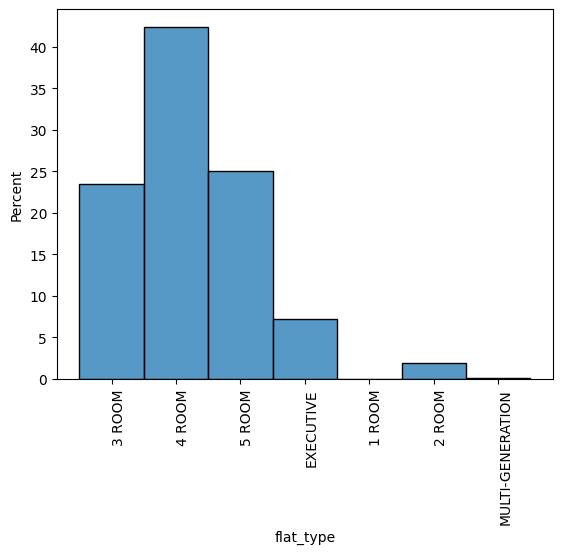

In [6]:
sns.histplot(x='flat_type',
             data=data,
             stat="percent")

# # Show the plot
# plt.show()
plt.xticks(rotation=90, ha='left', rotation_mode='default');

#### From the count plot above we can see that there are very little one room, two room and multi-generatin flat(below 5%). therefore we are going to drop these data for our model training.

In [7]:
data = data[data['flat_type'] != "1 ROOM"]
data = data[data['flat_type'] != "2 ROOM"]
data = data[data['flat_type'] != "MULTI-GENERATION"]

C:\Users\csc94\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\csc94\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\csc94\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


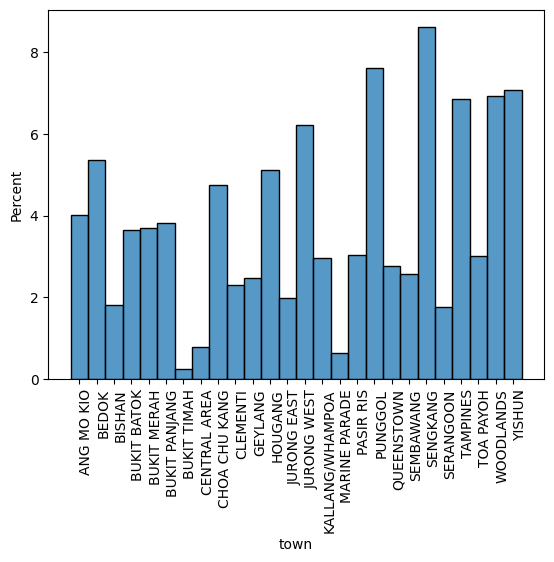

In [8]:
sns.histplot(x='town',
             data=data,
             stat="percent")
plt.xticks(rotation=90, ha='left', rotation_mode='default');

#### From the count plot above we can see that there are very little ales recoed in Central Area, Bukit Timah and Marine Parade(below 1%).therefore we are going to drop these data for our model training.


In [9]:
data = data[data['town'] != "CENTRAL AREA"]
data = data[data['town'] != "BUKIT TIMAH"]
data = data[data['town'] != "MARINE PARADE"]

#### Load the HDB location file, and join with the resale dataframe.  This will allow us to calculate the distance from the nearest mrt for each HDB blocks.

In [10]:
hdb_locations.rename(columns={"latitude": "lat", "longtitude": "lng",
                              "blk_no": "block", "RD_name": "street_name"},
                     inplace=True)
hdb_locations = hdb_locations[hdb_locations['postal.1'] != 189677]
hdb_locations = hdb_locations[hdb_locations['postal.1'] != 469277]
hdb_locations = hdb_locations[hdb_locations['postal'] != 90027]
hdb_locations = hdb_locations[["postal", "lat", "lng", "block", "street_name", "postal.1"]]
imputed_data = pd.merge(data, hdb_locations, how='left',
                        on=['block', 'street_name'])
imputed_data.dropna(inplace=True)

In [11]:
imputed_data

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price,year,price_per_sqm,postal,lat,lng,postal.1
0,2019-01-01,ANG MO KIO,3 ROOM,225,ANG MO KIO AVE 1,01 TO 03,67.0,New Generation,1978,58,230000.0,2019,3432.835821,560225.0,1.367396,103.838150,560225.0
1,2019-01-01,ANG MO KIO,3 ROOM,174,ANG MO KIO AVE 4,01 TO 03,60.0,Improved,1986,66,235000.0,2019,3916.666667,560174.0,1.375097,103.837619,560174.0
2,2019-01-01,ANG MO KIO,3 ROOM,440,ANG MO KIO AVE 10,04 TO 06,67.0,New Generation,1979,59,238000.0,2019,3552.238806,560440.0,1.366428,103.854311,560440.0
3,2019-01-01,ANG MO KIO,3 ROOM,174,ANG MO KIO AVE 4,10 TO 12,61.0,Improved,1986,66,240000.0,2019,3934.426230,560174.0,1.375097,103.837619,560174.0
4,2019-01-01,ANG MO KIO,3 ROOM,637,ANG MO KIO AVE 6,01 TO 03,68.0,New Generation,1980,60,240000.0,2019,3529.411765,560637.0,1.380362,103.842335,560637.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123032,2023-12-01,YISHUN,EXECUTIVE,606,YISHUN ST 61,07 TO 09,142.0,Apartment,1987,63,788888.0,2023,5555.549296,760606.0,1.421334,103.836318,760606.0
123033,2023-12-01,YISHUN,EXECUTIVE,643,YISHUN ST 61,10 TO 12,146.0,Maisonette,1987,63,838000.0,2023,5739.726027,760643.0,1.421335,103.837437,760643.0
123034,2023-12-01,YISHUN,EXECUTIVE,643,YISHUN ST 61,10 TO 12,142.0,Apartment,1987,63,755000.0,2023,5316.901408,760643.0,1.421335,103.837437,760643.0
123035,2023-12-01,YISHUN,EXECUTIVE,826,YISHUN ST 81,01 TO 03,142.0,Apartment,1988,64,780000.0,2023,5492.957746,760826.0,1.414174,103.832454,760826.0


## Data Enrichment
### We will try to enrich the data by calculating the distance of the HDB from MRT stations as we think distance to mrt station might be a good predictor

#### Here we will clean the mrt_locations data to remove the unnecessary data

In [12]:
mrt_locations.head()

,Unnamed: 0,OBJECTID,STN_NAME,STN_NO,geometry,Latitude,Longitude
0,0,1,EUNOS MRT STATION,EW7,POINT (103.9032524667383 1.319778951553637),1.319779,103.903252
1,1,2,CHINESE GARDEN MRT STATION,EW25,POINT (103.7325967380734 1.342352820874744),1.342353,103.732597
2,2,3,KHATIB MRT STATION,NS14,POINT (103.8329799077383 1.417383370153547),1.417383,103.832980
3,3,4,KRANJI MRT STATION,NS7,POINT (103.7621654109002 1.425177698770448),1.425178,103.762165
4,4,5,REDHILL MRT STATION,EW18,POINT (103.816816670149 1.289562726402453),1.289563,103.816817


In [13]:
mrt_locations.drop(columns=['Unnamed: 0', 'OBJECTID',
                            'geometry', "STN_NO", ], inplace=True)

In [14]:
mrt_locations.rename(columns={"Latitude": "lat", "Longitude": "lng"}, inplace=True)

In [15]:
mrt_locations.head()

,STN_NAME,lat,lng
0,EUNOS MRT STATION,1.319779,103.903252
1,CHINESE GARDEN MRT STATION,1.342353,103.732597
2,KHATIB MRT STATION,1.417383,103.832980
3,KRANJI MRT STATION,1.425178,103.762165
4,REDHILL MRT STATION,1.289563,103.816817


#### This is the formula to convert from euclidean distance to earth distance
#### Formula taken from https://byteshiva.medium.com/navigate-the-world-a-guide-to-calculating-distances-between-points-on-earth-using-python-and-the-9f3c5c856203

In [16]:
def calculate_distance(x, y):
    R = 6371  # Radius of the Earth in kilometers

    lat_a, lon_a = x[0], x[1]
    lat_b, lon_b = y[0], y[1]
    # Convert latitude and longitude to radians
    lat_a, lon_a, lat_b, lon_b = np.radians([lat_a, lon_a, lat_b, lon_b])

    # Calculate the difference in latitude and longitude
    dlat = lat_b - lat_a
    dlon = lon_b - lon_a

    # Apply the Haversine formula
    a = np.sin(dlat / 2) ** 2 + np.cos(lat_a) * np.cos(lat_b) * np.sin(dlon / 2) ** 2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    distance = R * c

    return distance

#### Here we import the KNN package to calculate the distance between each HDB block and the nearest mrt

In [17]:
from sklearn.neighbors import KNeighborsClassifier

nbrs = KNeighborsClassifier(n_neighbors=1, algorithm='ball_tree',
                            metric=calculate_distance).fit(mrt_locations[['lat', 'lng']],
                                                           mrt_locations['STN_NAME'])

imputed_data['mrt_dist'] = nbrs.kneighbors(imputed_data[['lat', 'lng']])[0]

imputed_data['nearest_mrt'] = nbrs.predict(imputed_data[['lat', 'lng']])

In [18]:
imputed_data.head()

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price,year,price_per_sqm,postal,lat,lng,postal.1,mrt_dist,nearest_mrt
0,2019-01-01,ANG MO KIO,3 ROOM,225,ANG MO KIO AVE 1,01 TO 03,67.0,New Generation,1978,58,230000.0,2019,3432.835821,560225.0,1.367396,103.838150,560225.0,0.541992,MAYFLOWER MRT STATION
1,2019-01-01,ANG MO KIO,3 ROOM,174,ANG MO KIO AVE 4,01 TO 03,60.0,Improved,1986,66,235000.0,2019,3916.666667,560174.0,1.375097,103.837619,560174.0,0.346258,MAYFLOWER MRT STATION
2,2019-01-01,ANG MO KIO,3 ROOM,440,ANG MO KIO AVE 10,04 TO 06,67.0,New Generation,1979,59,238000.0,2019,3552.238806,560440.0,1.366428,103.854311,560440.0,0.585051,ANG MO KIO MRT STATION
3,2019-01-01,ANG MO KIO,3 ROOM,174,ANG MO KIO AVE 4,10 TO 12,61.0,Improved,1986,66,240000.0,2019,3934.426230,560174.0,1.375097,103.837619,560174.0,0.346258,MAYFLOWER MRT STATION
4,2019-01-01,ANG MO KIO,3 ROOM,637,ANG MO KIO AVE 6,01 TO 03,68.0,New Generation,1980,60,240000.0,2019,3529.411765,560637.0,1.380362,103.842335,560637.0,0.329216,YIO CHU KANG MRT STATION


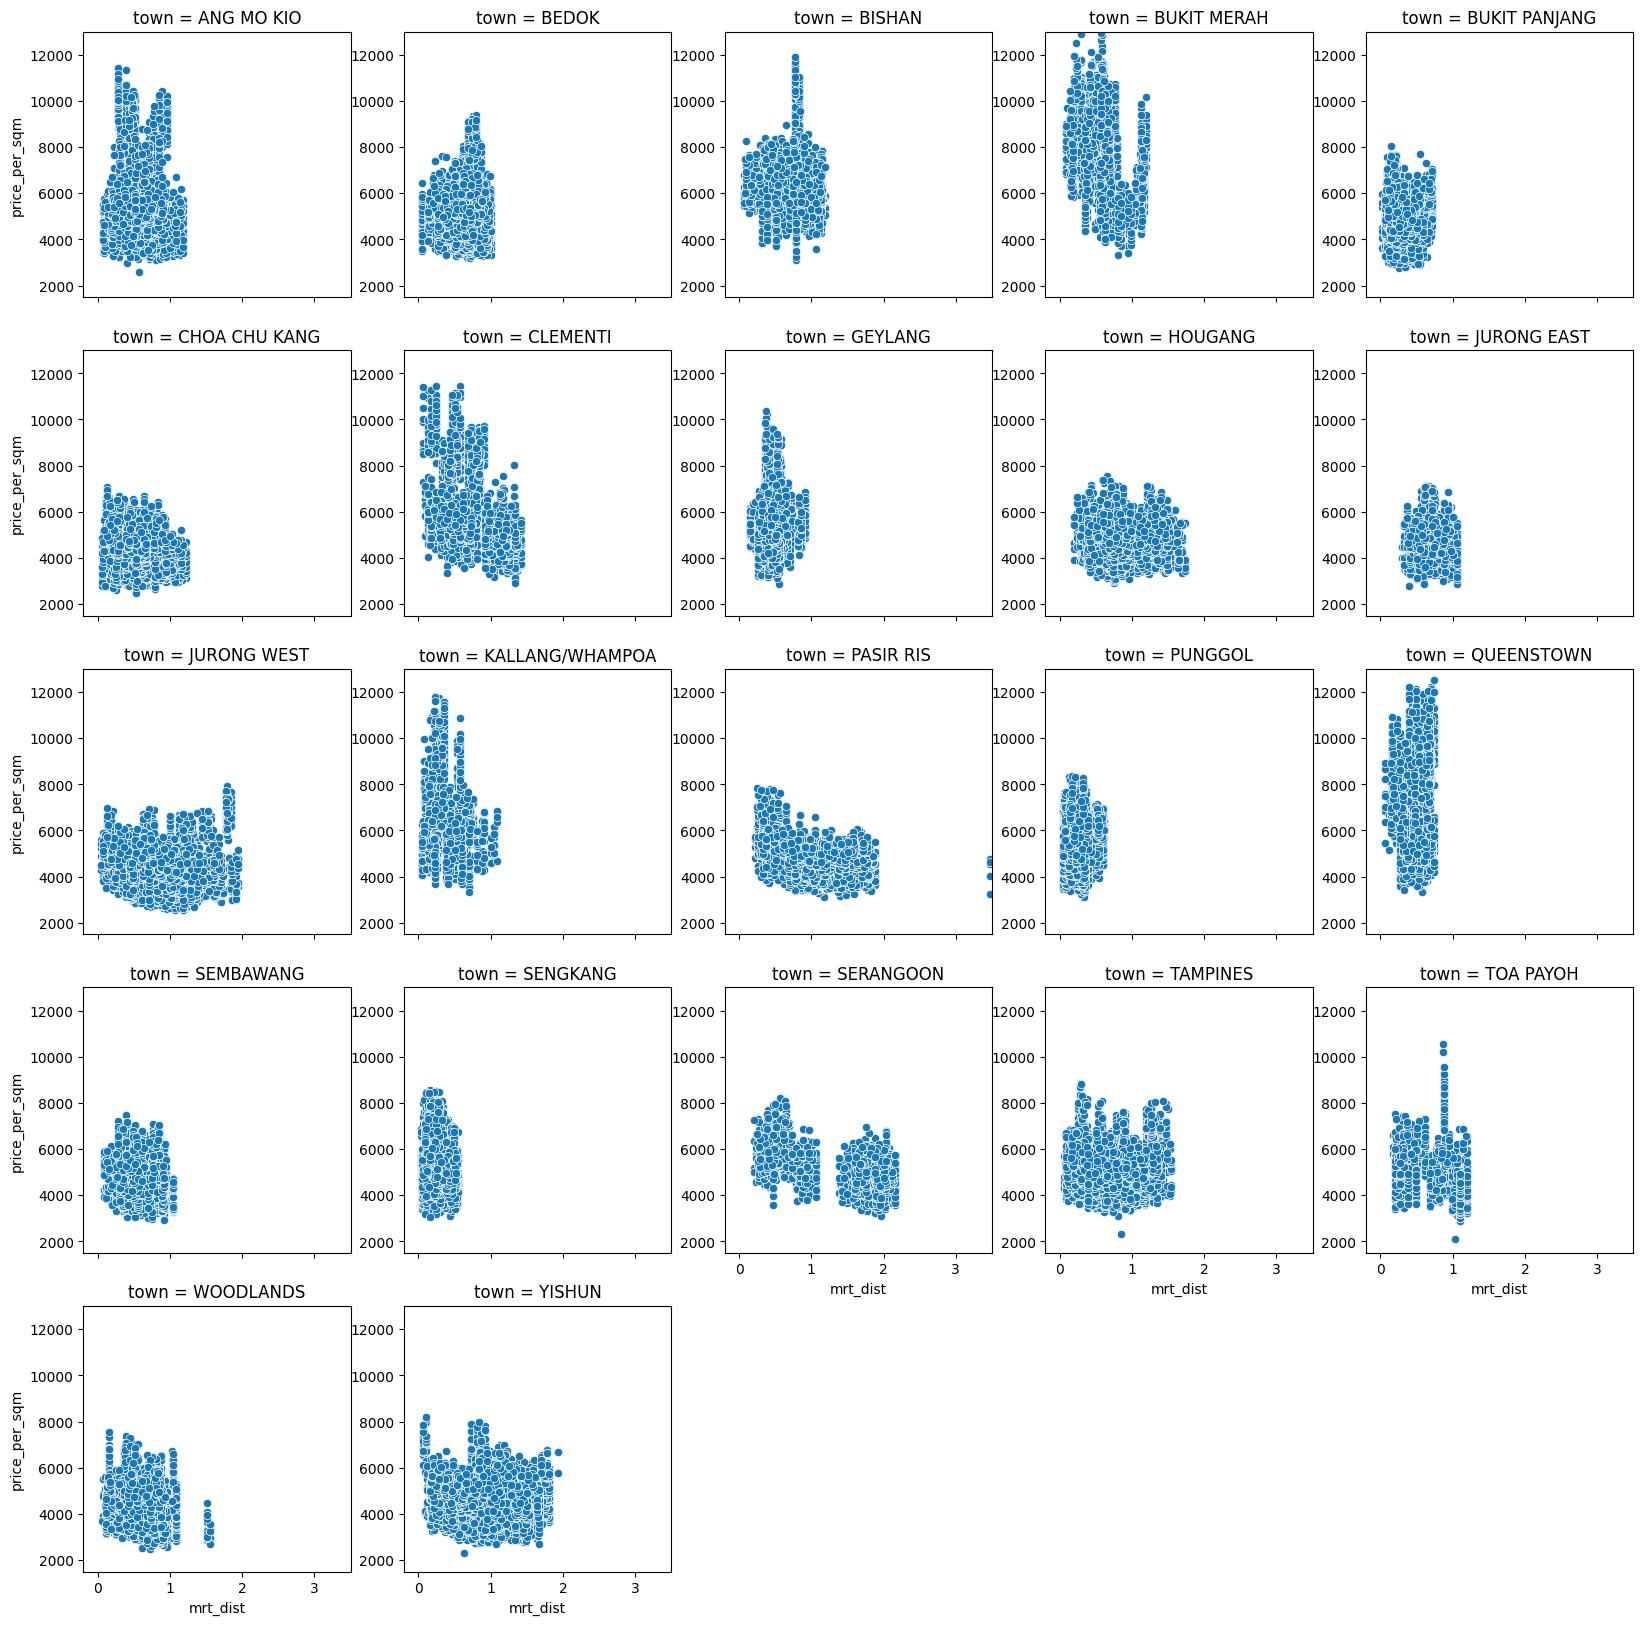

In [19]:
UniqueNames = imputed_data['town'].unique()

#create a data frame dictionary to store your data frames
DataFrameDict = {elem: pd.DataFrame() for elem in UniqueNames}

for key in DataFrameDict.keys():
    DataFrameDict[key] = imputed_data[imputed_data.town == key]
f = plt.figure(figsize=(20, 20))
for i in range(len(UniqueNames)):
    column = i // 5
    row = i % 5
    axis = f.add_subplot(5, 5, i + 1)
    dataset = UniqueNames[i]
    title = "town = " + dataset
    axis.scatter(DataFrameDict[dataset]['mrt_dist'],
                 DataFrameDict[dataset]['price_per_sqm'],
                 color='#1978b9',
                 edgecolors='white',
                 linewidth=0.5)
    axis.set_xlim([-0.2, 3.5])
    axis.set_ylim([1500, 13000])
    axis.set_xticks([0, 1, 2, 3])
    axis.set_title(title)

    if i >= 17:
        axis.set(xlabel='mrt_dist')
    else:
        axis.tick_params(colors='black', which='major', axis='x', labelcolor='white')
    if row == 0:
        axis.set(ylabel='price_per_sqm')





#### From the chart of price_per_sqm versus mrt_dist plot we generated for each town, we there is not a correlation between price and mrt distancefor most of the towns. Thus, the mrt_dist might be a useful predictor when training our model.

In [20]:
imputed_data

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price,year,price_per_sqm,postal,lat,lng,postal.1,mrt_dist,nearest_mrt
0,2019-01-01,ANG MO KIO,3 ROOM,225,ANG MO KIO AVE 1,01 TO 03,67.0,New Generation,1978,58,230000.0,2019,3432.835821,560225.0,1.367396,103.838150,560225.0,0.541992,MAYFLOWER MRT STATION
1,2019-01-01,ANG MO KIO,3 ROOM,174,ANG MO KIO AVE 4,01 TO 03,60.0,Improved,1986,66,235000.0,2019,3916.666667,560174.0,1.375097,103.837619,560174.0,0.346258,MAYFLOWER MRT STATION
2,2019-01-01,ANG MO KIO,3 ROOM,440,ANG MO KIO AVE 10,04 TO 06,67.0,New Generation,1979,59,238000.0,2019,3552.238806,560440.0,1.366428,103.854311,560440.0,0.585051,ANG MO KIO MRT STATION
3,2019-01-01,ANG MO KIO,3 ROOM,174,ANG MO KIO AVE 4,10 TO 12,61.0,Improved,1986,66,240000.0,2019,3934.426230,560174.0,1.375097,103.837619,560174.0,0.346258,MAYFLOWER MRT STATION
4,2019-01-01,ANG MO KIO,3 ROOM,637,ANG MO KIO AVE 6,01 TO 03,68.0,New Generation,1980,60,240000.0,2019,3529.411765,560637.0,1.380362,103.842335,560637.0,0.329216,YIO CHU KANG MRT STATION
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123032,2023-12-01,YISHUN,EXECUTIVE,606,YISHUN ST 61,07 TO 09,142.0,Apartment,1987,63,788888.0,2023,5555.549296,760606.0,1.421334,103.836318,760606.0,0.575068,KHATIB MRT STATION
123033,2023-12-01,YISHUN,EXECUTIVE,643,YISHUN ST 61,10 TO 12,146.0,Maisonette,1987,63,838000.0,2023,5739.726027,760643.0,1.421335,103.837437,760643.0,0.662240,KHATIB MRT STATION
123034,2023-12-01,YISHUN,EXECUTIVE,643,YISHUN ST 61,10 TO 12,142.0,Apartment,1987,63,755000.0,2023,5316.901408,760643.0,1.421335,103.837437,760643.0,0.662240,KHATIB MRT STATION
123035,2023-12-01,YISHUN,EXECUTIVE,826,YISHUN ST 81,01 TO 03,142.0,Apartment,1988,64,780000.0,2023,5492.957746,760826.0,1.414174,103.832454,760826.0,0.361608,KHATIB MRT STATION


In [21]:
mrt_locations

,STN_NAME,lat,lng
0,EUNOS MRT STATION,1.319779,103.903252
1,CHINESE GARDEN MRT STATION,1.342353,103.732597
2,KHATIB MRT STATION,1.417383,103.832980
3,KRANJI MRT STATION,1.425178,103.762165
4,REDHILL MRT STATION,1.289563,103.816817
...,...,...,...
166,SPRINGLEAF MRT STATION,1.398161,103.818082
167,LENTOR MRT STATION,1.385062,103.836469
168,MAYFLOWER MRT STATION,1.372087,103.836824
169,BRIGHT HILL MRT STATION,1.363308,103.832936


### Visualisation

##### To visualise the hot spot where of hdb location and their distance to the mrt stations, we have plot the graph below resembling the Singapore map

C:\Users\csc94\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\csc94\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\csc94\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\csc94\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is depr

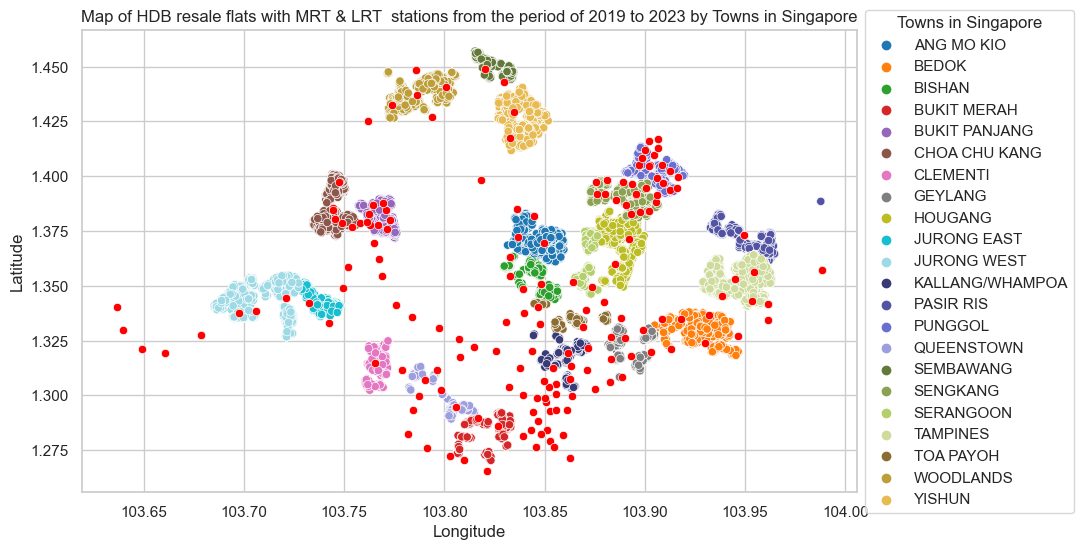

In [22]:
map_town_data = pd.DataFrame({"Latitude": imputed_data["lat"],
                              "Longitude": imputed_data["lng"],
                              "Town": imputed_data["town"]})

train_map_data = pd.DataFrame({"Latitude": mrt_locations["lat"],
                               "Longitude": mrt_locations["lng"]})

custom_palette = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22',
                  '#17becf', '#9edae5', '#393b79', '#5254a3', '#6b6ecf', '#9c9ede', '#637939', '#8ca252', '#b5cf6b',
                  '#cedb9c', '#8c6d31', '#bd9e39', '#e7ba52']

sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))

sns.scatterplot(x="Longitude", y="Latitude", hue="Town", data=map_town_data, palette=custom_palette)
sns.scatterplot(x="Longitude", y="Latitude", data=train_map_data, facecolor="red", edgecolor="white")
plt.legend(title="Towns in Singapore", loc="center left", bbox_to_anchor=(1, 0.5))

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Map of HDB resale flats with MRT & LRT  stations from the period of 2019 to 2023 by Towns in Singapore")

plt.show()

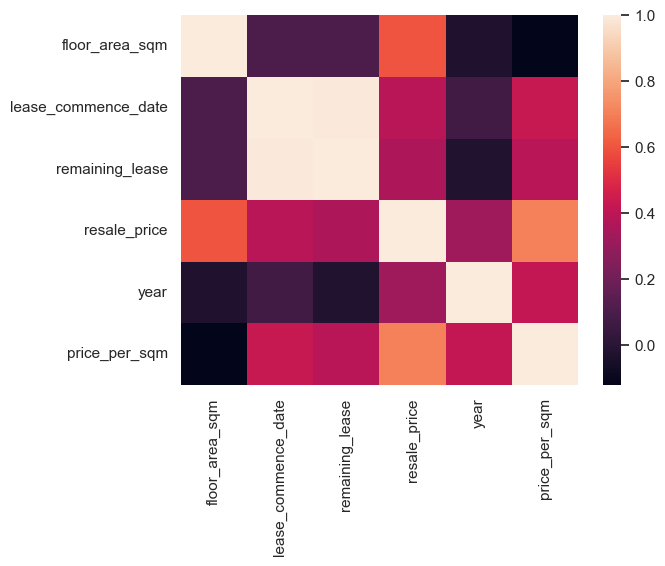

In [23]:
corr_matrix = data.select_dtypes(include=['float64', 'int64']).corr()
sns.heatmap(corr_matrix)
plt.show()

#### From the heatmap shown above, we theorised that floor_area_sqm and remaining_lease will be a good predictor of resale price, while mrt_dist will not contribute much in predicting the resale_price

# Task 5: Modeling and visualization



#### Feature selection for model training

##### To reduce the complexity of the model and prevent model overfitting, we have discarded:
###### 1) features which are too sparse(block & street name)
###### 2) features which are similar(lease commence date) - the value is already calculated and represented by remaining lease

In [25]:
data = imputed_data[
    ["month", "town", "flat_type", "storey_range", "floor_area_sqm", "flat_model", "remaining_lease", "mrt_dist",
     "resale_price"]]

In [26]:
data.to_csv('output.csv', index=False)

#### Step 3: Modelling

#### 1) Linear Regression Model

We train a linear regression model as a baseline where we will improve on it using more complicated models which utilises techniques such as cross validation, baggging, stacking and ensembling.

In [27]:
data = pd.read_csv('output.csv')

In [28]:
# Data preparation
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, root_mean_squared_error

# Split data into predictors and target
X = data.drop('resale_price', axis=1)
X = X.drop('month', axis=1)
y = data['resale_price']

# Split the dataset into training (90%) and test (10%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)

#### Preprocessing for categorical features

##### Before piping the data into the regression model, we performi 1 hot encoding to transform Categorial data (which are text data) into one hot encoding to match the input format of the  Linear Regressor

In [30]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Define columns that need encoding
categorical_features = ['town', 'flat_type', 'storey_range', 'flat_model']

# OneHotEncoder for categorical data within a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough'  # Include all other columns in the model unchanged
)

# Create a pipeline that includes preprocessing and the linear model
LR_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Train the model
LR_model.fit(X_train, y_train)

# Predict on the test data
y_pred = LR_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)

print('RMSE: {:.2f}'.format(rmse))
print('MAE: {:.2f}'.format(mae))
print('r2: {:.2f}'.format(r2))

RMSE: 79845.38
MAE: 64428.10
r2: 0.77


#### 2) Decision Tree

With the baseline identified, we proceeded to experiment with more complex models such as DecisionTreeRegressor. The DecisionTreeRegressor is a versatile machine learning model used for regression tasks that predicts continuous outcomes by splitting data into increasingly homogeneous subsets. It constructs a tree-like model of decisions based on the values of the input features, making it highly interpretable and easy to visualize.

By using the decision tree regressor, we are able to improve the RMSE from 79845 to 54105, with a 47% improvement.

In [31]:
from sklearn.tree import DecisionTreeRegressor

DT_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', DecisionTreeRegressor(random_state=42))
])

# Train the model
DT_model.fit(X_train, y_train)

# Predict on the test data
y_pred = DT_model.predict(X_test)

# Evaluate the model

r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)

print('RMSE: {:.2f}'.format(rmse))
print('MAE: {:.2f}'.format(mae))
print('r2: {:.2f}'.format(r2))

RMSE: 54104.85
MAE: 36034.01
r2: 0.90


#### 3) Hyperparameter tuning on Decision Tree Regressor

Then, the model is finetuned by optimizing the parameters that govern the training process. In the cell below, we test various combinations of hyperparameters to determine the most effective settings for the Decision Tree Regressor including, max_depth, min_samples_split and min_samples_leaf. 

It shows significant improvement (6.1%)  with the RMSE decreasing from 54105 to 50984.

In [ ]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'regressor__max_depth': [None, 10, 20, 30],  # Maximum number of levels in each tree
    'regressor__min_samples_split': [2, 10, 20],  # Minimum number of samples required to split an internal node
    'regressor__min_samples_leaf': [1, 5, 10]  # Minimum number of samples required to be at a leaf node
}

grid_search = GridSearchCV(estimator=DT_model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5, verbose=1)

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Get the best parameters and best score
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

best_model = grid_search.best_estimator_

# Predict on the test data
y_pred = best_model.predict(X_test)

# Evaluate the model

r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)

print('RMSE: {:.2f}'.format(rmse))
print('MAE: {:.2f}'.format(mae))
print('r2: {:.2f}'.format(r2))

Fitting 5 folds for each of 36 candidates, totalling 180 fits


#### 4) AutoML

By referring to the paper [AutoGluon-Tabular](https://arxiv.org/pdf/2003.06505.pdf), we have tried the best performing AutoML model which is able to automatically select relevant models based on our modelling task (regression) such as KNN, RandomForest, LightGBM, XGBoost. Then, a final model is trained using ensembling where the output of the most performant models are weighted.

By doing so, we are able to reduce the RMSE from 50984 to 25716.

![Local Image](./images/AutoGluon_Ensembling.png)

In [ ]:
# Initialisation
from autogluon.tabular import TabularDataset, TabularPredictor

# Train test split
train, test = train_test_split(data, test_size=0.1, random_state=0)
train_data = TabularDataset(train)
test_data = TabularDataset(test)


In [ ]:
label = 'resale_price'
save_path = './AutogluonModels/small'
try:
    predictor = TabularPredictor.load(save_path)
except:
    # Retraining will take around 60 seconds
    presets = ['good_quality', 'optimize_for_deployment']
    predictor = TabularPredictor(label=label, path=save_path).fit(train_data, presets=presets, time_limit=60)

In [ ]:
predictor.evaluate(test_data)

In [ ]:
results = predictor.evaluate(test_data)

print('RMSE: {:.2f}'.format(-results['root_mean_squared_error']))
print('MAE: {:.2f}'.format(-results['mean_absolute_error']))
print('r2: {:.2f}'.format(results['r2']))

#### Feature importance
By calculating the feature importance scores for the given model via permutation importance, we found that the town and flat_type of the hdb flat have the highest importance when predicting the resale price.

In [ ]:
predictor.feature_importance(test_data)

## Demo

##### With the trained model, we are able to test out our model for our potential users (potential buyer searching for HDB flat near NUS on PropertyGuru):

In [ ]:
# Search criteria: a relatively new house near NUS
month = '2024-04-24'
town = 'CLEMENTI'
flat_type = '3 ROOM'
storey_range = '10 TO 12'
floor_area_sqm = 90
flat_model = 'New Generation'
remaining_lease = 90
mrt_distance = 1.0

# hdb_search = data.sample(1)

hdb_search = pd.DataFrame([[month, town, flat_type, storey_range, floor_area_sqm, flat_model, remaining_lease, mrt_distance]] , columns = ["month", "town", "flat_type", "storey_range", "floor_area_sqm", "flat_model", "remaining_lease", "mrt_dist"])
hdb_search

In [ ]:
predictor.predict(hdb_search)

## Conclusion

In the data preparation stage, we selected the most relevant data by filtering out the outliers. We also enriched the data by calculating the distance of mrt to hdb.

In the EDA stage, we visualised the data to have a better understanding of the data and plotted a correlation matrix in a heatmap. We also preprocessed the data by applying one hot encoding on categorical data.

In the modelling stage, we saw that even simple model like linear regression can get a relatively good prediction. However, we found out that more complex model just as Decision Tree Regression is able to get a better results, and can be further enhance using hyperparameter tuning. Lastly, we also tried out the state of the art model which utilises ensembling for best model performance.

In the feature importance analysis, we also confirmed our hypothesis when calculating the correlation matrix, where mrt_distance does not really contribute in the prediction of sales price. 

In conclusion, we have successfully trained a highly accurate sales price prediction model with a 5.1% error (RMSE = 25716, mean = 507,654) after going through the steps of EDA, data enrichment, data preparation and modelling.


